In [147]:
# full_scanvi_pipeline.py
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scvi
from scvi.model import SCANVI
from datetime import datetime
from tqdm import tqdm
import pathlib as pl

In [2]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Download the data

In [3]:
bulk_train_x = pd.read_csv("data/train_data/train_bulk.csv", index_col=0)
bulk_train_y = pd.read_csv("data/train_data/train_bulk_trueprops.csv", index_col=0)
bulk_test_x = pd.read_csv("data/test_data/test_bulk.csv", index_col=0)

In [ ]:
train_adata = sc.read_h5ad("data/train_data/train_adata.h5ad")


In [ ]:

test_adata = sc.read_h5ad("data/test_data/test_adata.h5ad")

In [ ]:
print(train_adata.var.shape) # gene level
train_adata.var.head()

(7725, 6)


,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


In [ ]:
print(train_adata.obs.shape) # cell level
train_adata.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [ ]:
print(train_adata.X.shape) # expression of the cells by genes

(32374, 7725)


# Step 1: Perform SC clustering 

In [26]:
label_key = "highLevelType"
categorical_covariate_keys = ["Sample", "Tumor status", "Patient"]
batch_key = "Sample"

In [ ]:
# sc.pp.filter_cells(train_adata, min_genes=200)
sc.pp.filter_genes(train_adata, min_cells=3)

train_adata.layers["counts"] = train_adata.X.copy()  # preserve counts
sc.pp.normalize_total(train_adata, target_sum=1e4)
sc.pp.log1p(train_adata)
train_adata.raw = train_adata

In [ ]:
sc.pp.highly_variable_genes(
    train_adata,
    flavor="seurat_v3",
    n_top_genes=1200,
    subset=True,
    layer="counts",
    batch_key=batch_key,
)

In [ ]:
scvi.model.SCVI.setup_anndata(
    train_adata,
    layer="counts",
    labels_key=label_key,
    categorical_covariate_keys=categorical_covariate_keys,
)

In [ ]:
model = scvi.model.SCVI(train_adata)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [35]:
model.train(early_stopping=True, max_epochs=200, check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [30:16<00:00,  8.17s/it, v_num=1, train_loss=486]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [30:16<00:00,  9.08s/it, v_num=1, train_loss=486]


In [36]:
tstamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f"data/model/{tstamp}_scvi_model"
model.save(model_filename)

In [ ]:
Z_train = model.get_latent_representation()

# Attach latent to original objects (so downstream Scanpy neighbors/leiden work)
train_adata.obsm["X_scANVI"] = Z_train

Without batch correction

In [ ]:
sc.tl.pca(train_adata)

In [ ]:
sc.pp.neighbors(train_adata, n_pcs=30, n_neighbors=20, use_rep="X_pca")
sc.tl.umap(train_adata, min_dist=0.3)

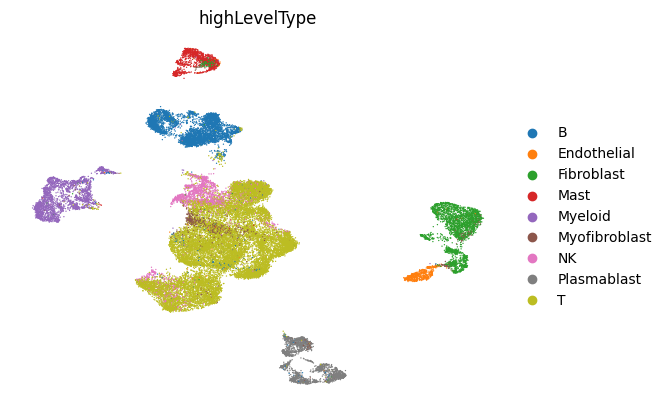

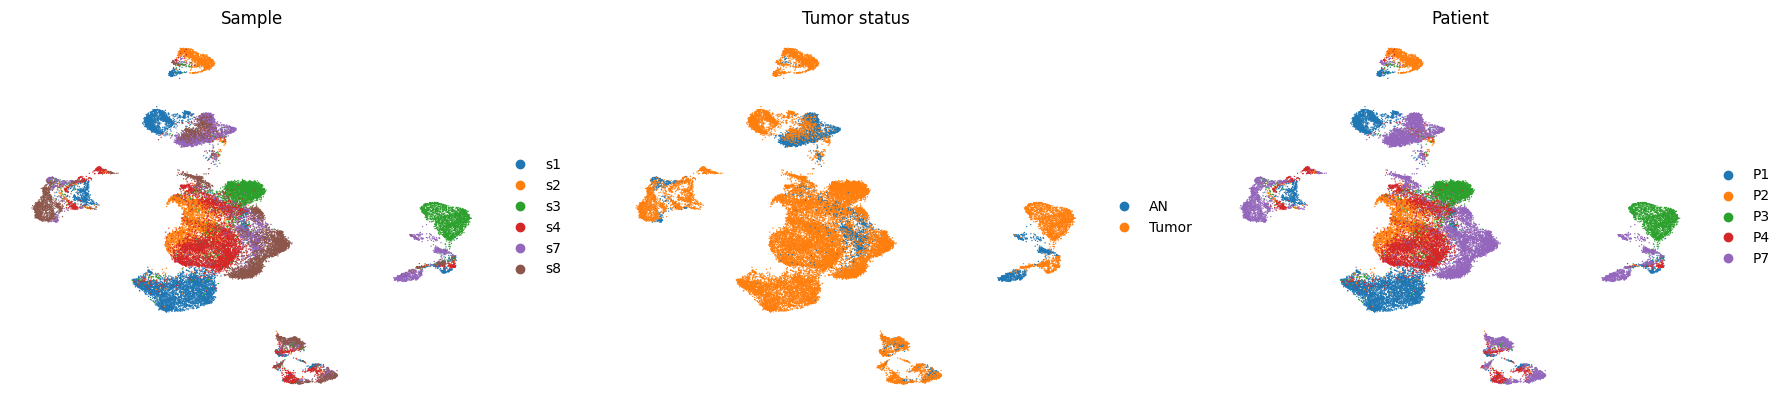

In [ ]:
sc.pl.umap(
    train_adata,
    color=[label_key],
    frameon=False,
)

sc.pl.umap(
    train_adata,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

In [ ]:
sc.pp.neighbors(train_adata, use_rep="X_scANVI", n_neighbors=20)
sc.tl.umap(train_adata, min_dist=0.3)

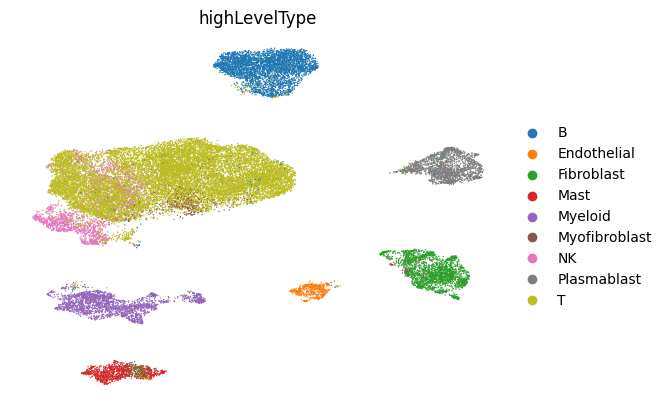

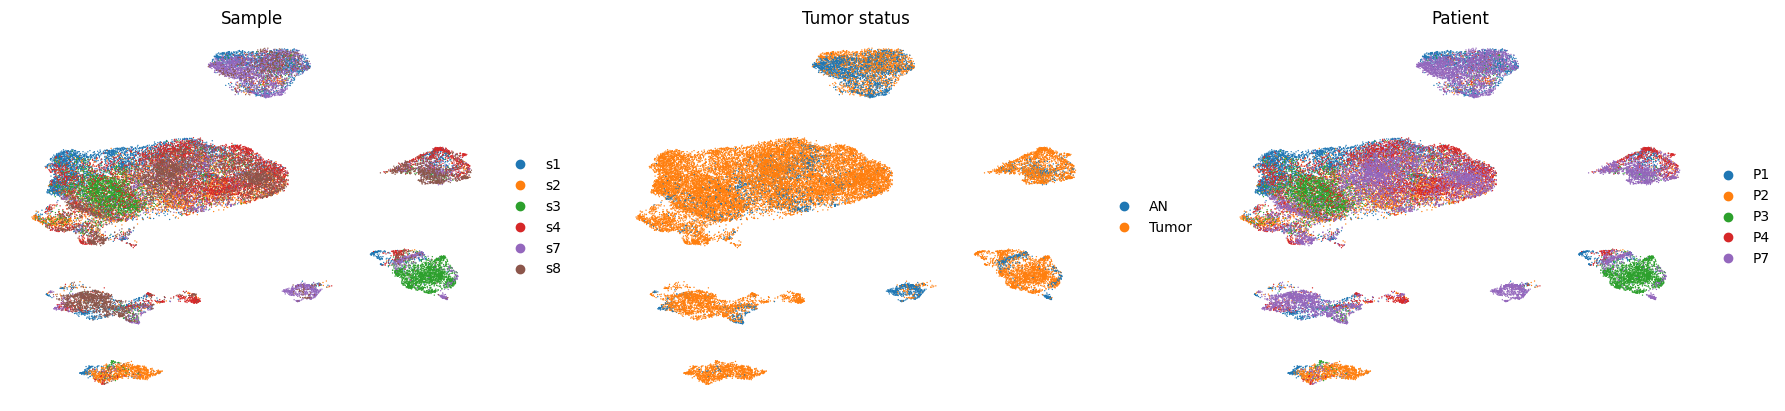

In [ ]:
sc.pl.umap(
    train_adata,
    color=[label_key],
    frameon=False,
)

sc.pl.umap(
    train_adata,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

In [ ]:
# resolution search helper
def search_best_resolution(adata, true_label_key="highLevelType", nsteps=30, low=0.2, high=1.5):
    true_labels = adata.obs[true_label_key].values
    best_score = -1.0
    best_res = None
    for r in tqdm(np.linspace(low, high, nsteps)):
        tmp = adata.copy()
        sc.tl.leiden(tmp, resolution=float(r), key_added="tmp_cluster")
        pred = tmp.obs["tmp_cluster"].astype(str).values
        ari = adjusted_rand_score(true_labels, pred)
        v = v_measure_score(true_labels, pred)
        score = (ari + v) / 2
        if score > best_score:
            best_score = score
            best_res = float(r)
            print(f"New best resolution: {best_res} with score {best_score}")
    return best_res, best_score

best_res, best_score = search_best_resolution(train_adata, true_label_key="highLevelType", nsteps=30, low=0.01, high=.4)
print("Best resolution chosen (train):", best_res, "score:", best_score)

  3%|▎         | 1/30 [00:17<08:19, 17.23s/it]

New best resolution: 0.01 with score 0.6048557551552908


  7%|▋         | 2/30 [00:31<07:08, 15.29s/it]

New best resolution: 0.023448275862068966 with score 0.7931025014089681


 10%|█         | 3/30 [00:45<06:43, 14.93s/it]

New best resolution: 0.03689655172413793 with score 0.7934278758691524


 13%|█▎        | 4/30 [01:05<07:14, 16.72s/it]

New best resolution: 0.0503448275862069 with score 0.8057574960391112


 17%|█▋        | 5/30 [01:32<08:36, 20.67s/it]

New best resolution: 0.06379310344827586 with score 0.8078684524568678


 40%|████      | 12/30 [04:31<07:31, 25.09s/it]

New best resolution: 0.15793103448275864 with score 0.8097120053679159


100%|██████████| 30/30 [15:41<00:00, 31.37s/it]

Best resolution chosen (train): 0.15793103448275864 score: 0.8097120053679159


In [ ]:
sc.tl.leiden(train_adata, resolution=best_res)

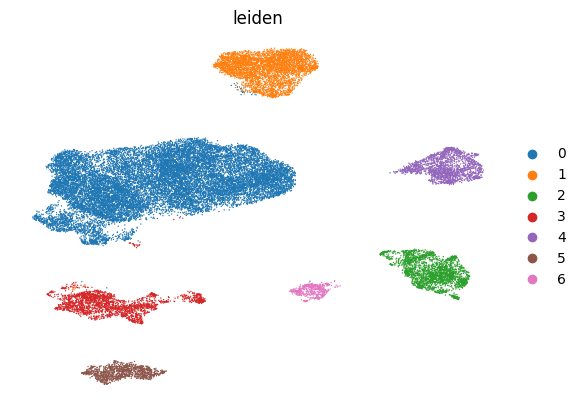

In [ ]:
sc.pl.umap(
    train_adata,
    color=['leiden'],
    frameon=False,
)


## Step 1bis: Predict on test data


In [ ]:
test_adata.shape

(18616, 1200)

In [ ]:
selected_genes = train_adata.var_names.tolist()

test_adata = test_adata[:, selected_genes].copy()
test_adata.layers["counts"] = test_adata.X.copy()  # preserve counts
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)
test_adata.raw = test_adata



In [ ]:
test_adata.obs[label_key] = "Unknown"
model_test = scvi.model.SCVI.load_query_data(
    test_adata,
    model,
)

In [113]:
model_test.train(early_stopping=True, max_epochs=200, check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 44/200:  22%|██▏       | 43/200 [02:29<08:43,  3.34s/it, v_num=1, train_loss=541]

/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
test_adata.obsm["X_scVI"] = model_test.get_latent_representation()

In [ ]:
sc.pp.neighbors(test_adata, use_rep="X_scVI")
sc.tl.leiden(test_adata, resolution=best_res)
sc.tl.umap(test_adata)

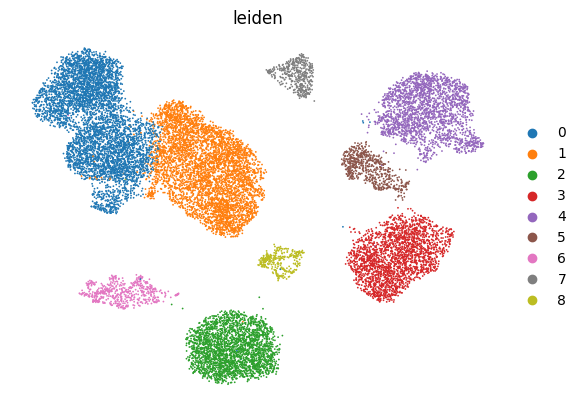

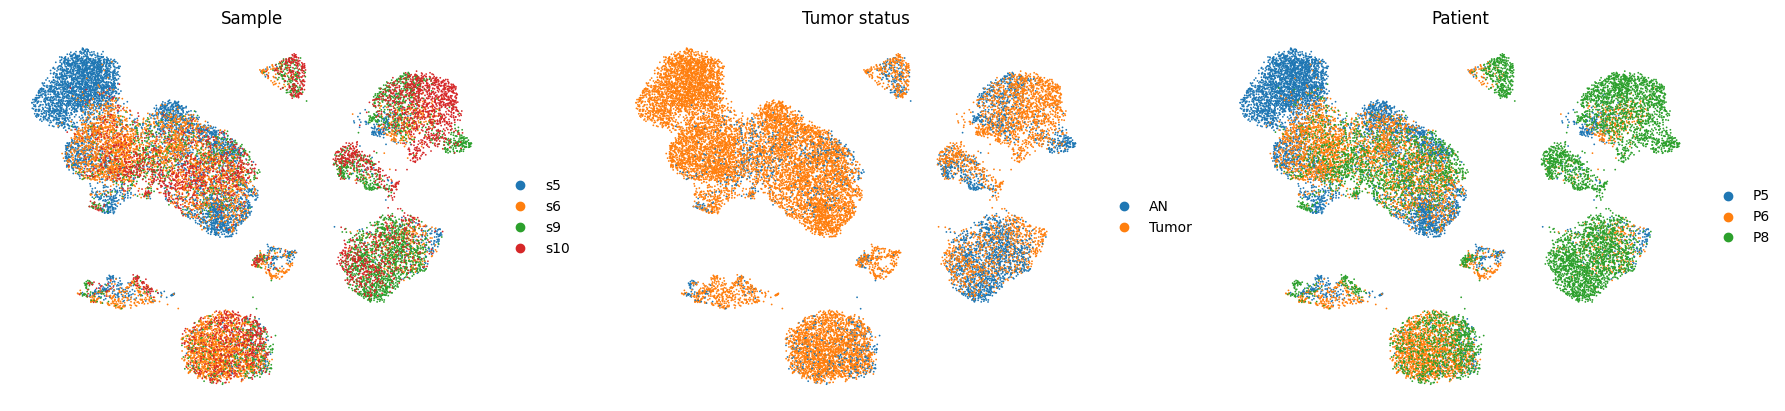

In [ ]:
sc.pl.umap(
    test_adata,
    color=['leiden'],
    frameon=False,
)

sc.pl.umap(
    test_adata,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

In [ ]:
adata_full = test_adata.concatenate(train_adata)

adata_full.obsm["X_scVI"] = model_test.get_latent_representation(adata_full)

/tmp/ipykernel_850228/3524862153.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_full = sc_test.concatenate(sc_train)


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.umap(adata_full)

In [131]:
sc.tl.leiden(adata_full, resolution=0.05)

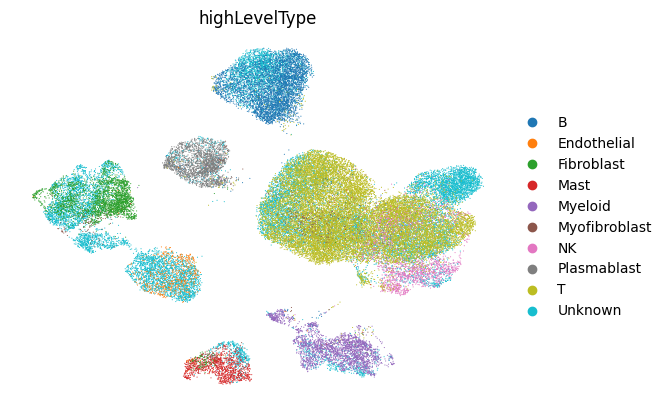

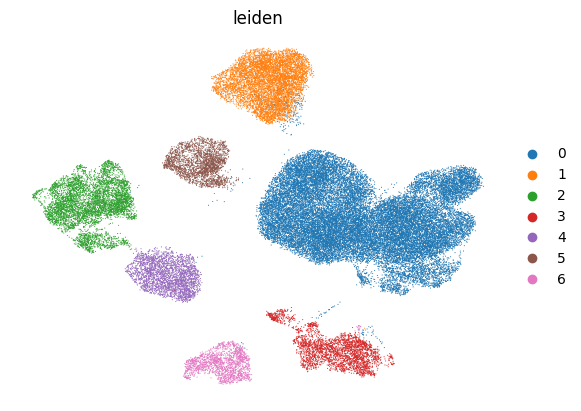

In [132]:
sc.pl.umap(
    adata_full,
    color=[label_key],
    frameon=False,
    ncols=1,
)

sc.pl.umap(
    adata_full,
    color=['leiden'],
    frameon=False,
    ncols=1,
)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_adata.obsm["X_scANVI"], train_adata.obs["leiden"])
test_adata.obs['knn_cluster'] = knn.predict(test_adata.obsm["X_scVI"])

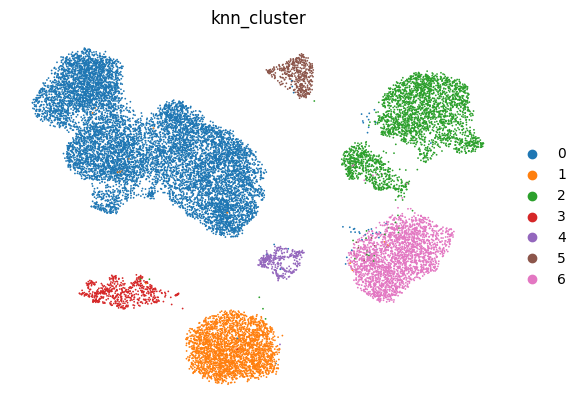

In [ ]:
sc.pl.umap(
    test_adata,
    color=['knn_cluster'],
    frameon=False,
    ncols=1,
)

In [ ]:
results = test_adata.obs[["knn_cluster"]].reset_index().rename(columns={"knn_cluster": "cluster"})
results.to_csv("results/cluster_membership_plaf.csv", index=True)
results

,index,cluster
0,AAACCCAAGGAGGCAG-1_5,0
1,AAACCCAAGTTGCGCC-1_5,0
2,AAACCCACACGGATCC-1_5,0
3,AAACCCACATCGGAAG-1_5,0
4,AAACCCAGTGCGAGTA-1_5,0
...,...,...
18611,TTTGGTTCATTGAAGA-1_10,0
18612,TTTGGTTGTTGTCCCT-1_10,2
18613,TTTGGTTGTTTGACAC-1_10,0
18614,TTTGTTGAGGGTCAAC-1_10,0


# Step 2: Deconvolve the data

# Step 2bis: Predict on the test data

In [ ]:
# Method 1: KNN clustering in latent space
# Train KNN on the training latent representation and cluster labels
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(train_adata.obsm["X_scANVI"], train_adata.obs["cluster"])

# Predict clusters for test data
test_adata.obs["cluster"] = knn.predict(test_adata.obsm["X_scANVI"])

print(f"Test data clustered into {test_adata.obs['cluster'].nunique()} clusters")
print(f"Cluster distribution:\n{test_adata.obs['cluster'].value_counts().sort_index()}")

In [ ]:
# Optionally save predicted labels (with cell barcodes in index)
df_test = test_adata.obs[["cluster"]].reset_index().rename(columns={"index": "cell_id"})

In [ ]:
results = test_adata.obs["cluster"]
results = results.reset_index()

# Step 3: Save the required files

In [ ]:
# pred_props should be a DataFrame containing the estimated cell type proportions for the patients in all_bulkified
# pred_props.columns = ['index','s5_0','s5_1',...,'s10_3','s10_4'] = np.append(["index"],all_bulkified.columns)
# pred_props['index'] = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
#       'NK', 'Myeloid', 'Mast']

In [ ]:
results_path = pl.Path("results")

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [153]:
pred_props = pd.read_csv("results/pred_props.csv", index_col=0)
cluster_labels = pd.read_csv("results/cluster_membership_plaf.csv", index_col=0)

In [154]:
import zipfile

tstamp = datetime.now().strftime("%Y%m%d_%H%M%S")
archive_name = f"{tstamp}_Project2.zip" # TODO

with zipfile.ZipFile(pl.Path("data/submissions/") / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        pred_props.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()